In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
Marseille=pd.read_csv("../stage/final_marseille.csv")
Marseille.head()

,Unnamed: 0,datetime,PM25_Marseille_Longchamp,difficultés respiratoires,asthme,dyspnée,respiration,banane,banane_topic,la diarrhée,la diarrhée_topic,pollution de l’air,pollution de l’air_topic
0,0,2017-08-31 00:00:00,8.0,0,13,0,0,46,54,NaN,NaN,NaN,NaN
1,1,2017-08-31 01:00:00,9.0,0,0,0,79,23,35,NaN,NaN,NaN,NaN
2,2,2017-08-31 02:00:00,8.0,0,0,23,46,27,41,NaN,NaN,NaN,NaN
3,3,2017-08-31 03:00:00,7.0,0,0,0,68,10,20,NaN,NaN,NaN,NaN
4,4,2017-08-31 04:00:00,8.0,0,0,0,26,42,52,NaN,NaN,NaN,NaN


In [3]:
def signal_process(table,event_var='PM25_Marseille_Longchamp',event_threshold = 40, duration = 6,var_name_list='air pollution'):
    """collect time segments when pm2.5 hit above cetrain threshold non-overlap in a single day  
    param:
    event_var: str
        critical variable we would like to observe and select time segment based on it
    event_threshold: int
        critical value when event_var go above it
    duration: int 
        time length, lag of window
    var_name_list: list
        variable list that we would like to watch
    """
    
    assert(hasattr(table,"datetime"))
    table["date"] = list(map(lambda date: datetime.strptime(date,"%Y-%m-%d %H:%M:%S").date(),table.datetime))
    
    index_list=np.where(table[event_var]>event_threshold)[0]
    
    # add first element
    shrink_index_list = [index_list[0]]
    date_set ={table.date[index_list[0]]}
    
 
    for cnt in range(1,len(index_list)):
# #         exclude for the same day
#         if table.date[index_list[cnt]] in date_set:
#             pass
#         else:
            shrink_index_list.append(index_list[cnt].copy())
            date_set.add(table.date[index_list[cnt]])
    
    bind_list = []
    for start_index in shrink_index_list:
        this_sequence = table.loc[range(start_index-2,start_index+duration),
                                  var_name_list]
        start_date = table.datetime[start_index]
        tuples = list(zip([start_date]*(duration+2),range(-2,duration)))

        this_sequence.index = pd.MultiIndex.from_tuples(tuples,names=['event_date_index','hour_index'])
    #         this_sequence = (this_sequence- this_sequence.mean())/this_sequence.std()

        bind_list.append(this_sequence)
    new_table=pd.concat(bind_list)     
    
    return new_table

In [4]:
watch_list =["PM25_Marseille_Longchamp","asthme","dyspnée","respiration","banane"]

In [5]:
Marseille_post=signal_process(Marseille,event_var="PM25_Marseille_Longchamp",event_threshold=35,duration=12,var_name_list=watch_list)

In [6]:
Marseille_post.head(15)

PM25_Marseille_Longchamp  asthme  dyspnée  \
event_date_index    hour_index                                              
2017-09-30 23:00:00 -2                              30.0       6        3   
                    -1                              22.0       0        0   
                     0                              39.0      44        0   
                     1                              25.0       0        0   
                     2                              31.0       0        0   
                     3                              25.0      29        0   
                     4                               8.0      52       26   
                     5                               6.0       0        0   
                     6                               3.0       0        7   
                     7                               4.0      17        0   
                     8                               6.0       7        5   
                     9                              29.0       8        0   
                     10                             15.0       6        2   
                     11                             15.0      10        0   
2017-10-31 20:00:00 -2                              16.0       2        2   

                                respiration  banane  
event_date_index    hour_index                       
2017-09-30 23:00:00 -2                   28      32  
                    -1                   10      32  
                     0                   17      38  
                     1                   29       8  
                     2                   46      37  
                     3                    0       0  
                     4                   26      14  
                     5                   30      41  
                     6                    0      52  
                     7                   10      63  
                     8                    9      58  
                     9                   10      63  
                     10                  21      62  
                     11                  21      57  
2017-10-31 20:00:00 -2                    6      30

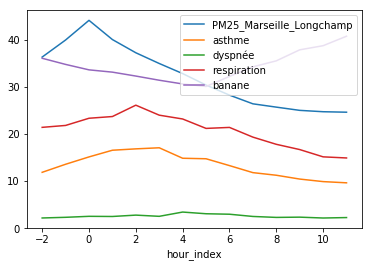

In [7]:
Marseille_post.groupby("hour_index").mean().plot()
plt.show()

In [9]:
Marseille_post.to_csv("../output/postmarceille_with_overlap.csv")